In [1]:
import os
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
import cv2
import math
import pandas as pd
from CSL_2025_Python_codes import spim2XYZ, XYZ2Lab
from functions import *

1. Load Spectral Reflectances Cubes

In [2]:
# Define folder path
base_folder = "../IDP Group A"

# Define wavelength list (450 nm to 950 nm in 20 nm steps)
wavelengths = list(range(450, 951, 20))

# Define subfolders
sample_folders = [f"d{i}" for i in range(1, 15)]  # d1 to d14
dark_folder = "dark"
white_folder = "white"
reference_folder = "reference image"

# Load white and dark images
def load_cube(folder_path):
    tif_files = [f for f in os.listdir(folder_path) if f.lower().endswith(".tif")]
    tif_files.sort()

    cube = []
    for tif_file in tif_files:
        tif_path = os.path.join(folder_path, tif_file)
        tif = tiff.imread(tif_path)
        cube.append(tif)

    cube = np.array(cube)

    return cube


# Load dark and white reference cubes
dark_cube = load_cube(os.path.join(base_folder, dark_folder))
white_cube = load_cube(os.path.join(base_folder, white_folder))
reference_cube = load_cube(os.path.join(base_folder, reference_folder))


# Avoid division by zero
denominator = white_cube - dark_cube
denominator[denominator == 0] = 1e-6

# Load and compute reflectance for each sample
defect_cubes = {}

for folder in sample_folders:
    sample_cube = load_cube(os.path.join(base_folder, folder))
    R = (sample_cube - dark_cube) / denominator
    defect_cubes[folder] = R  # Shape: (bands, height, width)

2. Load reference

In [3]:
R_sample = (reference_cube - dark_cube) / denominator

band = 550 # Band for alignment

ref_rgb = extract_RGB(R_sample, wavelengths)
ref_mask = compute_IC_mask(ref_rgb)
ref_single_band = R_sample[wavelengths.index(band), :, :]
ref_binary = convert_binary_image(ref_single_band)

print(f"Reflectance shape: {R_sample.shape}")
print(f"RGB shape: {ref_rgb.shape}")
print(f"Mask shape: {ref_mask.shape}")
print(f"Single band shape: {ref_single_band.shape}")
print(f"Binary shape: {ref_binary.shape}")

Reflectance shape: (26, 1040, 1392)
RGB shape: (1040, 1392, 3)
Mask shape: (1040, 1392)
Single band shape: (1040, 1392)
Binary shape: (1040, 1392)


3. Find Homography matrix for the alignment of each defect

In [4]:
defect_homographies = []
defects = sample_folders
for defect in defects:
    print(f"\nAligning {defect}...")

    defect_rgb = extract_RGB(defect_cubes[defect], wavelengths)
    defect_binary = convert_binary_image(get_example_reflectance(defect_cubes, defect, band))
    H = align_and_visualise_homography(ref_binary, defect_binary, defect, visualise=False)
    defect_homographies.append(H)

    if ref_rgb.dtype != np.uint8:
        ref_rgb = np.clip(ref_rgb * 255, 0, 255).astype(np.uint8)
    if defect_rgb.dtype != np.uint8:
        defect_rgb = np.clip(defect_rgb * 255, 0, 255).astype(np.uint8)

    # aligned_defect, blended = align_and_blend_RGB_homography(ref_rgb, defect_rgb, H, defect)
    # overlay_mask(defect_rgb, ref_mask, defect, color=(1, 0, 0), alpha=0.5)
    # overlay_mask(aligned_defect, ref_mask, f"aligned_{defect}", color=(1, 0, 0), alpha=0.5)


Aligning d1...

Aligning d2...

Aligning d3...

Aligning d4...

Aligning d5...

Aligning d6...

Aligning d7...

Aligning d8...

Aligning d9...

Aligning d10...

Aligning d11...

Aligning d12...

Aligning d13...

Aligning d14...


4. Circle info

In [5]:
circle_info = get_circle_info(ref_mask)
print(f"circle_info: {circle_info}")

# print(f"len(defect_homographies): {len(defect_homographies)}")
# print(f"defect_homographies: {defect_homographies}")
# print(f"defect_homographies[0]: {defect_homographies[0]}")

circle_info: {'centroid': (191.98805403198608, 305.7539450094964), 'area': 9389.5, 'perimeter': 366.91882729530334, 'min_enclosing_circle': {'center': (191.6385040283203, 305.6613464355469), 'radius': 56.829063415527344}, 'ellipse': ((191.98439025878906, 305.7358093261719), (106.03638458251953, 112.76265716552734), 4.824965953826904), 'circularity': 0.8764201151536154}


5. Crop circle

In [ ]:
circle_info = get_circle_info(ref_mask)
if ref_rgb.dtype != np.uint8:
    ref_rgb = np.clip(ref_rgb * 255, 0, 255).astype(np.uint8)

circle_center = circle_info["min_enclosing_circle"]["center"]
circle_radius = circle_info["min_enclosing_circle"]["radius"]
ref_cropped = crop_circle(ref_rgb, circle_center, circle_radius)
cropped_circles = [ref_cropped]
ref_spectrum = average_reflectance_in_circle(R_sample, circle_center, circle_radius)
spectra = {"reference": ref_spectrum}


R_sample_interp, new_wavelengths = interpolate_spectral_cube(R_sample, wavelengths, wl_min=360, wl_max=830, wl_step=10)
R_sample_interp = np.transpose(R_sample_interp, (1, 2, 0))  # (H, W, bands)

ref_XYZ = spim2XYZ(R_sample_interp, new_wavelengths, "D65")
ref_LAB = XYZ2Lab(ref_XYZ, new_wavelengths, "D65")

mask_ref = np.zeros(ref_LAB.shape[:2], dtype=np.uint8)
cx, cy = int(circle_center[0]), int(circle_center[1])
r = int(circle_radius) - 5
cv2.circle(mask_ref, (cx, cy), r, 1, -1)

deltaE_results = []
defects_radius = []

for i, defect_name in enumerate(defects):
    print(f"Processing {defect_name}...")

    # Matrix for alignment
    A_3x3 = defect_homographies[i]

    # Defect data
    defect_rgb = extract_RGB(defect_cubes[defect_name], wavelengths)
    defect_mask = compute_IC_mask(defect_rgb)
    defect_circle_info = get_circle_info(defect_mask)
    defects_radius.append(defect_circle_info["min_enclosing_circle"]["radius"])
    
    if defect_rgb.dtype != np.uint8:
        defect_rgb = np.clip(defect_rgb * 255, 0, 255).astype(np.uint8)

    # Align defect
    A_2x3 = A_3x3[:2, :]
    h, w, b = ref_rgb.shape
    aligned_defect = cv2.warpAffine(defect_rgb, A_2x3, (w, h))

    # Mask IC area
    cropped_circle = crop_circle(aligned_defect, circle_center, circle_radius)
    cropped_circles.append(cropped_circle)

    # Compute spectral average
    cube = defect_cubes[defect_name]
    A_3x3 = defect_homographies[i]
    spec = average_reflectance_in_circle(cube, circle_center, circle_radius, transform=A_3x3)
    spectra[defect_name] = spec

    bands, h, w = cube.shape

    # Align full cube
    cube_aligned = np.stack([
        cv2.warpAffine(cube[j], A_3x3[:2, :], (w, h))
        for j in range(bands)
    ])

    # Spectral to LAB
    cube_interp, _ = interpolate_spectral_cube(cube_aligned, wavelengths, wl_min=360, wl_max=830, wl_step=10)
    cube_interp = np.transpose(cube_interp, (1, 2, 0))  # (H, W, b)

    def_XYZ = spim2XYZ(cube_interp, new_wavelengths, "D65")
    def_LAB = XYZ2Lab(def_XYZ, new_wavelengths, "D65")

    # CIelab delta E with reference
    ΔE_mean = calculate_delta_E(ref_LAB, def_LAB, mask=mask_ref)
    deltaE_results.append({"defect": defect_name, "ΔE_mean": ΔE_mean})




Processing d1...

Processing d2...

Processing d3...

Processing d4...

Processing d5...

Processing d6...

Processing d7...

Processing d8...

Processing d9...

Processing d10...

Processing d11...

Processing d12...

Processing d13...

Processing d14...



Average ΔE (CIE76) values per defect:
   defect    ΔE_mean     radius
0      d1   4.268202  57.010201
1      d2   5.700859  56.792423
2      d3  10.903396  56.801151
3      d4   3.088835  56.904392
4      d5   8.952004  56.591911
5      d6   5.667816  56.711742
6      d7   5.938351  56.890343
7      d8   4.807428  71.632843
8      d9   3.843842  52.787407
9     d10   5.783827  50.913124
10    d11   4.894016  56.782578
11    d12   4.980802  56.661373
12    d13  10.955605  57.237038
13    d14   3.708490  70.952545


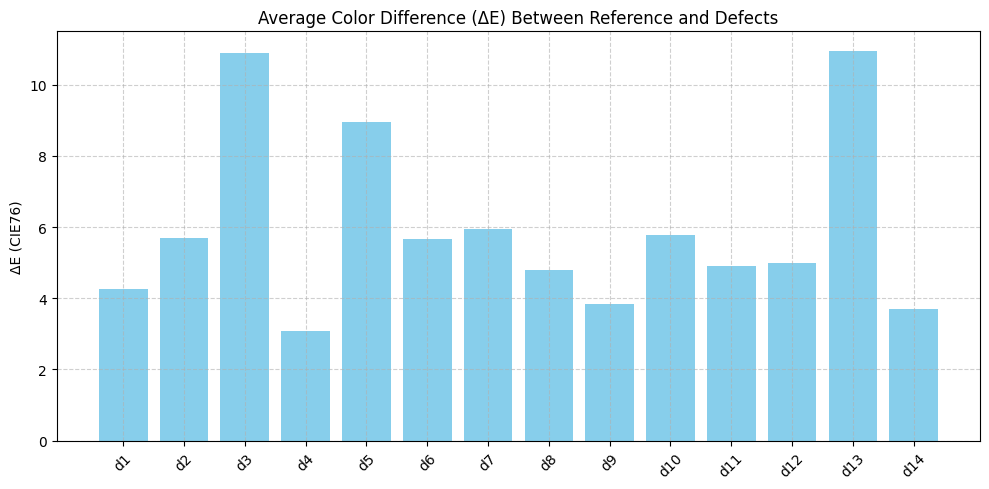

✅ Results saved to deltaE_results.csv


In [ ]:
deltaE_df = pd.DataFrame(deltaE_results)
deltaE_df['radius'] = defects_radius
print("\nAverage ΔE (CIE76) values per defect:")
print(deltaE_df)

plt.figure(figsize=(10, 5))
plt.bar(deltaE_df["defect"], deltaE_df["ΔE_mean"], color="skyblue")
plt.ylabel("ΔE (CIE76)")
plt.title("Average Color Difference (ΔE) Between Reference and Defects")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

deltaE_df.to_csv("deltaE_results.csv", index=False)

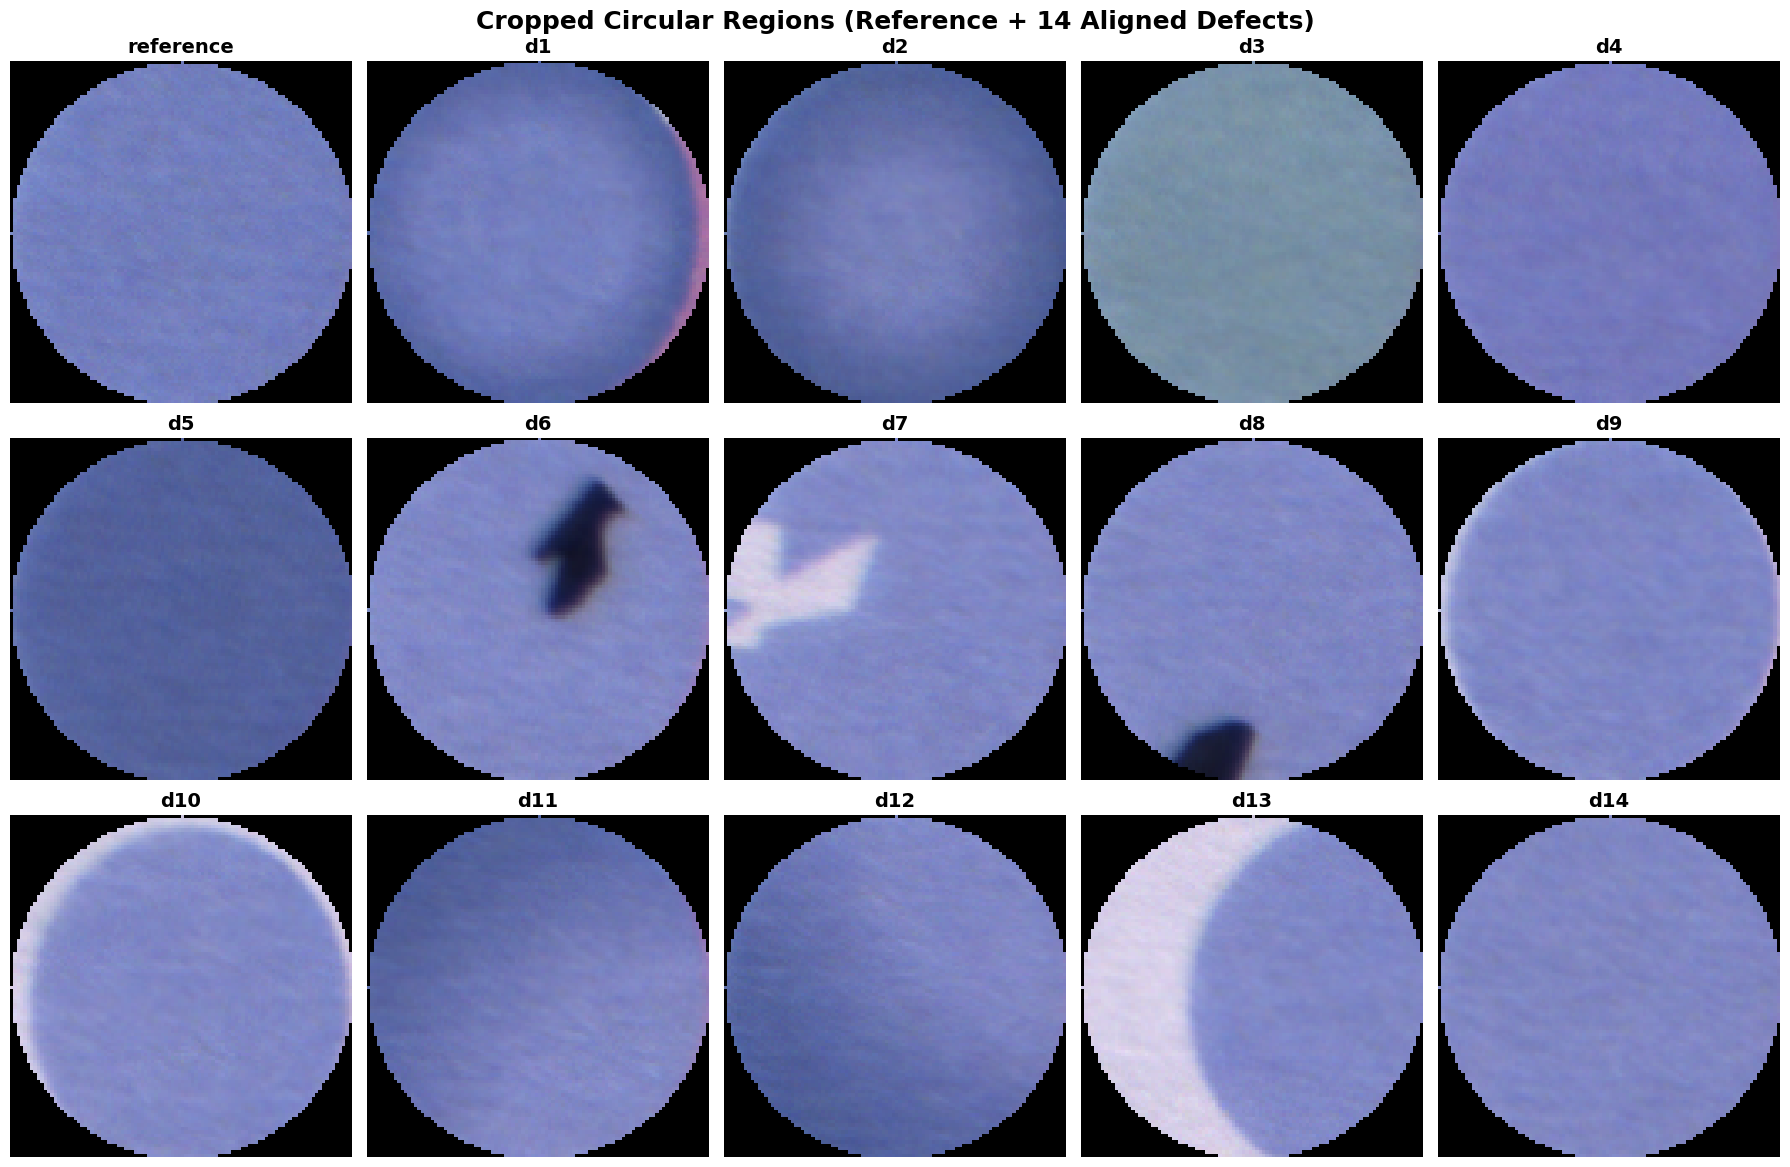

In [8]:
# Plot masked IC region
titles = ["reference"] + defects
plt.figure(figsize=(18, 12))
cols = 5
rows = math.ceil((len(defects) + 1) / cols)
for idx, (img, title) in enumerate(zip(cropped_circles, titles)):
    plt.subplot(rows, cols, idx + 1)
    if img.ndim == 2:
        plt.imshow(img, cmap="gray")
    else:
        plt.imshow(img)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.axis("off")

plt.suptitle("Cropped Circular Regions (Reference + 14 Aligned Defects)", fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()

6. Average reflectance in Circle

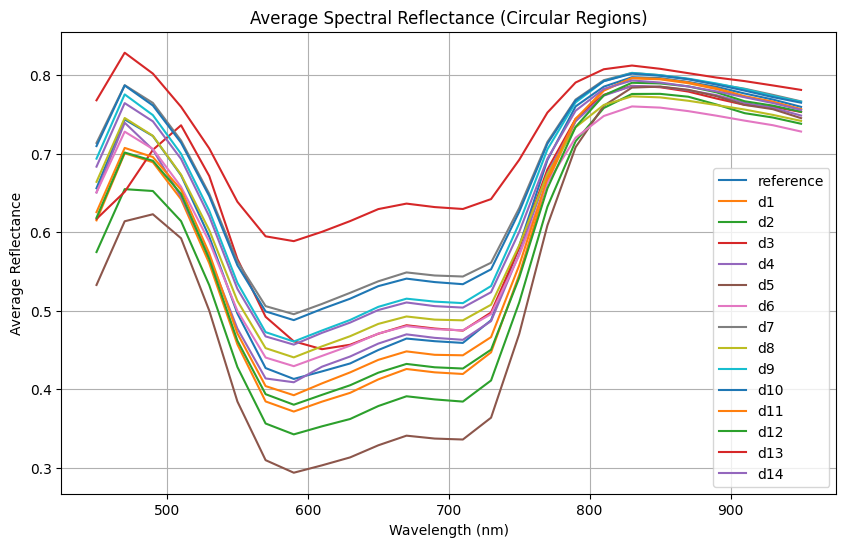

In [9]:
# Plot average spectra of each defect
plt.figure(figsize=(10, 6))
for name, spectrum in spectra.items():
    plt.plot(wavelengths, spectrum, label=name)

plt.xlabel("Wavelength (nm)")
plt.ylabel("Average Reflectance")
plt.title("Average Spectral Reflectance (Circular Regions)")
plt.legend()
plt.grid(True)
plt.show()